In [1]:
import os
import torch

os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

torch.set_default_device(device)
print(f"Using device = {torch.get_default_device()}")

Using device = cuda:0


In [2]:
from datasets import load_dataset
from transformers import BertTokenizer
import transformers
from torch.utils.data import DataLoader
from collections import Counter

dataset = load_dataset("Hacker0x01/hackerone_disclosed_reports")
dataset = dataset.filter(
    lambda example:
    example["title"] is not None and
    example["vulnerability_information"] is not None and
    example["weakness"] is not None
)
weakness_types = [item["weakness"]["name"] for item in dataset["train"]]
type_counter = Counter(weakness_types)
main_types = [k for k,v in type_counter.items() if v > type_counter.total()*0.0024]
main_types.append("Other")
print(main_types)
dataset = dataset.map(lambda example: {'label': main_types.index(example["weakness"]["name"]) if example["weakness"]["name"] in main_types else len(main_types)-1 })

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
def tokenize_function(example):
    return tokenizer(example["title"], example["vulnerability_information"], padding=True, max_length=512, truncation=True)
verbosity = transformers.logging.get_verbosity(); transformers.logging.set_verbosity_error()
tokenized_datasets = dataset.map(tokenize_function, batched=True)
transformers.logging.set_verbosity(verbosity)
tokenized_datasets = tokenized_datasets.select_columns(['input_ids', 'token_type_ids', 'attention_mask', 'label'])
tokenized_datasets.set_format("torch")

generator = torch.Generator(device=device)
train_dataloader = DataLoader(tokenized_datasets["train"], shuffle=True, batch_size=16, generator=generator)
validation_dataloader = DataLoader(tokenized_datasets["validation"], shuffle=True, batch_size=16, generator=generator)
test_dataloader = DataLoader(tokenized_datasets["test"], shuffle=True, batch_size=16, generator=generator)

/root/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['Improper Authorization', 'Improper Authentication - Generic', 'Command Injection - Generic', 'Cross-site Scripting (XSS) - Reflected', 'Insecure Storage of Sensitive Information', 'Cross-Site Request Forgery (CSRF)', 'Open Redirect', 'Cross-site Scripting (XSS) - Generic', 'Improper Access Control - Generic', 'Information Disclosure', 'UI Redressing (Clickjacking)', 'Privilege Escalation', 'Insufficiently Protected Credentials', 'Violation of Secure Design Principles', 'Improper Restriction of Authentication Attempts', 'Uncontrolled Resource Consumption', 'Information Exposure Through an Error Message', 'XML External Entities (XXE)', 'Business Logic Errors', 'SQL Injection', 'Cross-site Scripting (XSS) - Stored', 'Code Injection', 'HTTP Request Smuggling', 'Memory Corruption - Generic', 'Buffer Over-read', 'Use After Free', 'Server-Side Request Forgery (SSRF)', 'NULL Pointer Dereference', 'Insecure Direct Object Reference (IDOR)', 'Out-of-bounds Read', 'Cross-site Scripting (XSS) - D

## 加载模型

In [3]:
import torch.nn as nn
from transformers import BertModel

class BertClassifier(nn.Module):
    def __init__(self, num_labels):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("google-bert/bert-base-uncased")
        self.dropout = nn.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, **inputs):
        outputs = self.bert(**inputs)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

model = BertClassifier(num_labels=len(main_types))
model.load_state_dict(torch.load('./model_lr_5e-05_epoch_6_acc_0.60322.pt', weights_only=True, map_location=device))
model.eval()

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

## 评估模型

100%|██████████| 71/71 [00:32<00:00,  2.19it/s]


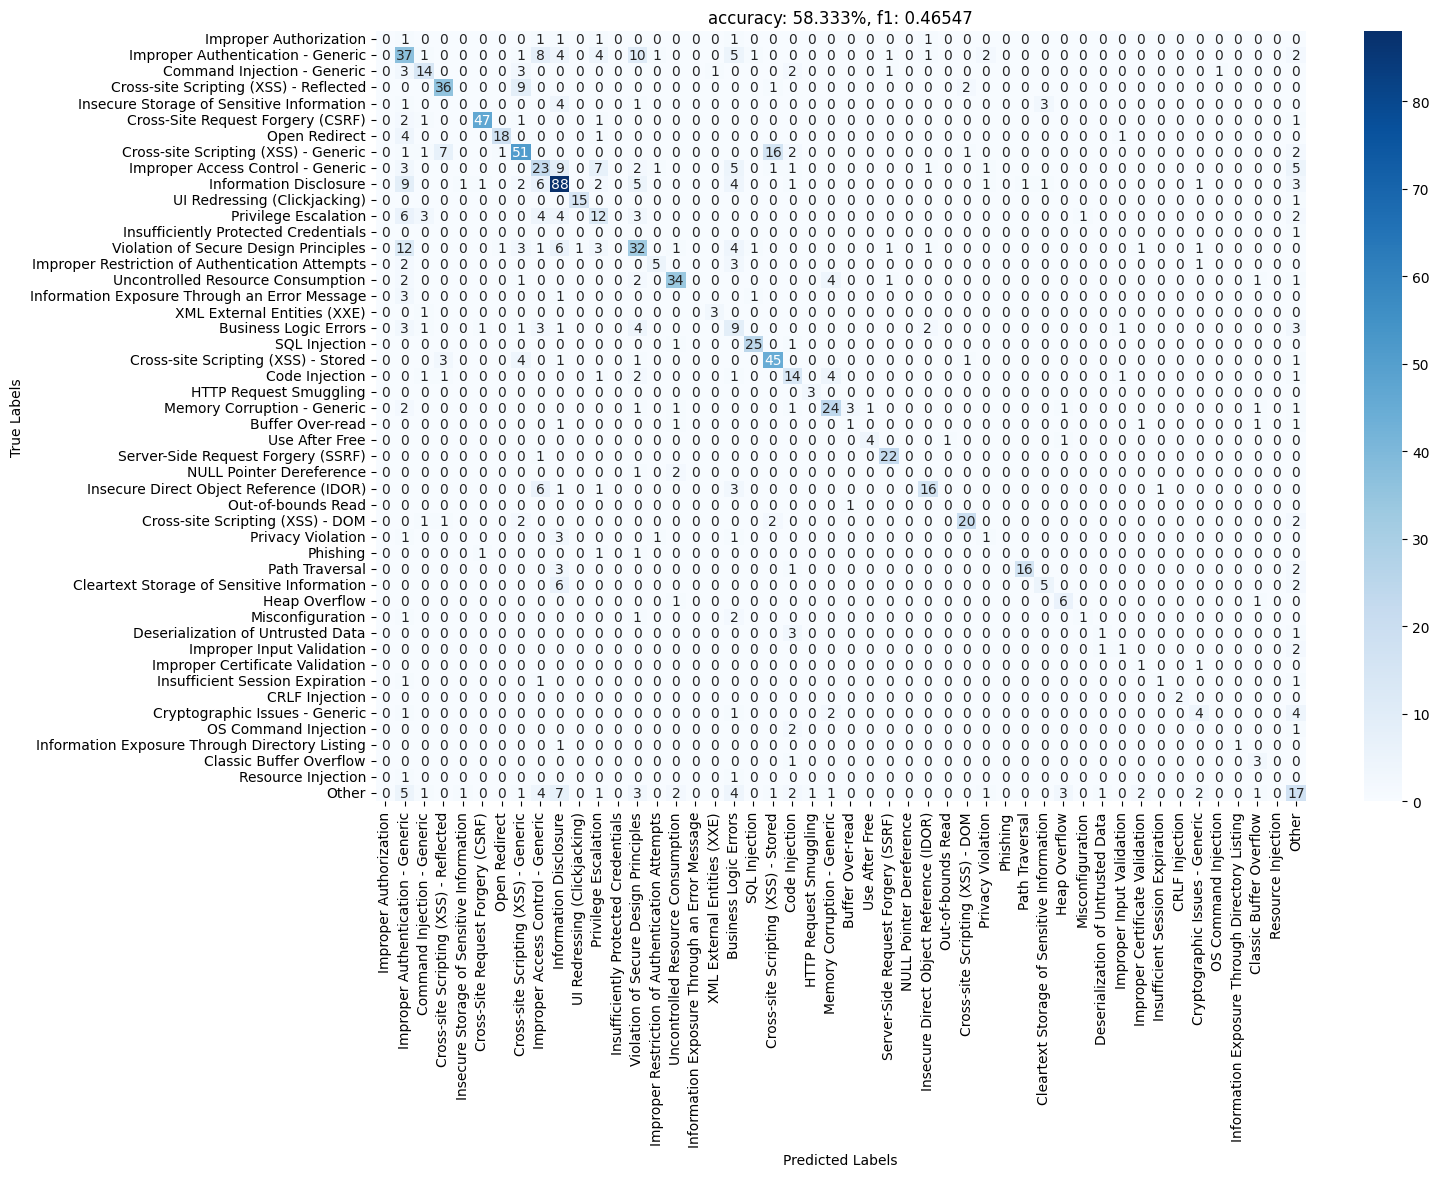

In [4]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

def evaluate(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            inputs = {
                "input_ids": batch["input_ids"], 
                "token_type_ids": batch['token_type_ids'], 
                "attention_mask": batch["attention_mask"]
            }
            outputs = model(**inputs)
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch["label"].cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)
    return accuracy, f1, cm

def plot_confusion_matrix(title, cm, labels):
    plt.figure(figsize=(15, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

accuracy, f1, cm = evaluate(model, test_dataloader)
plot_confusion_matrix(f'accuracy: {accuracy:.3%}, f1: {f1:.5}', cm, main_types)

## 获取指定数据

In [5]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")

all_preds = []
all_labels = []
all_input_ids = []
with torch.no_grad():
    for batch in test_dataloader:
        inputs = {
            "input_ids": batch["input_ids"], 
            "token_type_ids": batch['token_type_ids'], 
            "attention_mask": batch["attention_mask"]
        }
        outputs = model(**inputs)
        preds = outputs.argmax(1)
        labels = batch["label"]
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())
        all_input_ids.extend(inputs["input_ids"])

def get_datas(true_label_str, pred_label_str):
    true_label = main_types.index(true_label_str)
    pred_label = main_types.index(pred_label_str)
    datas = []
    for i in range(len(all_labels)):
        if all_labels[i] == true_label and all_preds[i] == pred_label:
            datas.append(tokenizer.decode(all_input_ids[i]))
    return datas

In [6]:
for data in get_datas('Cross-site Scripting (XSS) - Generic', 'Cross-site Scripting (XSS) - Stored'):
    print(data)

[CLS] xss in bootbox [SEP] hi. sorry for taking the time with this report. this is already publicly disclosed issue at - [ https : / / github. com / makeusabrew / bootbox / issues / 661 ] ( https : / / github. com / makeusabrew / bootbox / issues / 661 ) in essence all dialogs of bootbox vulnurable to xss injections ( bootbox. alert ( " \ < script \ > alert ( 1 ) ; \ < / script \ > " ) ; ) this is apparently a feature to allow injecting html in messages but it is not very clear from the documentation. even though this issue has been reported for a while no changes were made to fix this issue or even update the documentation kind regards, yoni # # impact websites using bootbox to display messages containing user input are vulnerable to xss [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

In [7]:
for data in get_datas('Command Injection - Generic', 'Improper Authentication - Generic'):
    print(data)

[CLS] admin panel accessed ( oauth bypassed ) [SEP] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 